# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../datasets/cleaned_dataset.csv')

df = df[[
         'HDays', 'ADays',
         'HASLxM', 'HASTLxM', 
         'HACLxM', 'HAFLxM', 'HAYCLxM', 'HARCLxM',
         'HAGSLxM', 'HAGCLxM', 'HAGSLxHM', 'HAGCLxHM',
         'HGDLxM', 'HGDLxHM', 'HAPLxM', 'HAPLxHM',
         'HWPLxM', 'HWPLxHM',
         'HWinStreak',
         'AASLxM', 'AASTLxM', 
         'AACLxM', 'AAFLxM', 'AAYCLxM', 'AARCLxM',
         'AAGSLxM', 'AAGCLxM', 'AAGSLxAM', 'AAGCLxAM',
         'AGDLxM', 'AGDLxAM', 'AAPLxM','AAPLxAM',
         'AWPLxM', 'AWPLxAM', 
         'AWinStreak', 
         'HDef', 'HMid', 'HAtt', 'HOvr',
         'ADef', 'AMid', 'AAtt', 'AOvr',
         'B365H', 'B365D', 'B365A',
         'Venue',
         'Result'
        ]]

df = df.dropna(axis=0).reset_index(drop=True)

# 3. Feature Selection

In [4]:
selected_features = ['HASLxM', 'HAGCLxM', 'HWPLxM', 'AASLxM', 'AAFLxM', 'AAGCLxM', 'AWPLxM', 'HOvr', 'AOvr', 'B365H', 'B365D','B365A', 'Venue']

# 4. Model Building- Data Split 3

- Target Variable: Win/Lose/Draw
- Stratified Sampling

In [5]:
# label encode categorical feature- VENUE
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

dict(zip(venue_le.classes_, range(len(venue_le.classes_))))

{'Anfield': 0,
 'Bet365 Stadium': 1,
 'Boleyn Ground': 2,
 'Bramall Lane': 3,
 'Brentford Community Stadium': 4,
 'Cardiff City Stadium': 5,
 'Carrow Road': 6,
 'Craven Cottage': 7,
 'DW Stadium': 8,
 'Dean Court': 9,
 'Elland Road': 10,
 'Emirates Stadium': 11,
 'Etihad Stadium': 12,
 'Falmer Stadium': 13,
 'Goodison Park': 14,
 'Hull City Stadium': 15,
 'King Power Stadium': 16,
 'Kirklees Stadium': 17,
 'Loftus Road': 18,
 'London Stadium': 19,
 'Madejski Stadium': 20,
 'Molineux Stadium': 21,
 'Old Trafford': 22,
 'Riverside Stadium': 23,
 'Selhurst Park': 24,
 "St Mary's Stadium": 25,
 'St. James Park': 26,
 'Stadium of Light': 27,
 'Stamford Bridge': 28,
 'Swansea.com Stadium': 29,
 'The Hawthorns': 30,
 'Tottenham Hotspur Stadium': 31,
 'Turf Moor': 32,
 'Vicarage Road': 33,
 'Villa Park': 34,
 'Wembley Stadium': 35,
 'White Hart Lane': 36}

### Random Forest Classifier

#### Fold 1

In [6]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1192
1     848
0     620
Name: Result, dtype: int64
2    298
1    211
0    155
Name: Result, dtype: int64


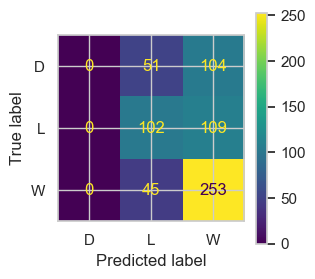

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [8]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5346385542168675
ROC score on Test Set: 0.6779973548501157

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.52      0.48      0.50       211
           2       0.54      0.85      0.66       298

    accuracy                           0.53       664
   macro avg       0.35      0.44      0.39       664
weighted avg       0.41      0.53      0.46       664



#### Fold 2

In [9]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


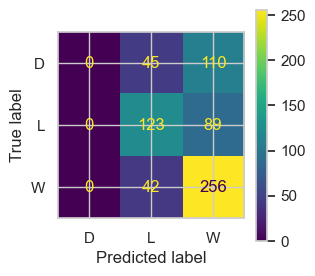

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5699248120300752
ROC score on Test Set: 0.7228761619670524

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.59      0.58      0.58       212
           2       0.56      0.86      0.68       298

    accuracy                           0.57       665
   macro avg       0.38      0.48      0.42       665
weighted avg       0.44      0.57      0.49       665



#### Fold 3

In [12]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


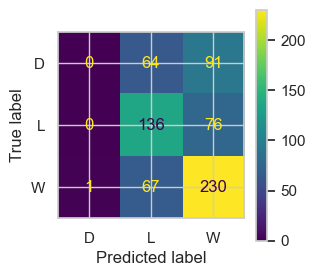

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5503759398496241
ROC score on Test Set: 0.7087464219620434

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.51      0.64      0.57       212
           2       0.58      0.77      0.66       298

    accuracy                           0.55       665
   macro avg       0.36      0.47      0.41       665
weighted avg       0.42      0.55      0.48       665



#### Fold 4

In [15]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


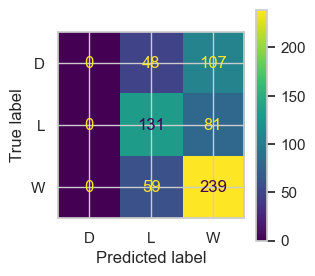

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.556390977443609
ROC score on Test Set: 0.7064630321857299

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.55      0.62      0.58       212
           2       0.56      0.80      0.66       298

    accuracy                           0.56       665
   macro avg       0.37      0.47      0.41       665
weighted avg       0.43      0.56      0.48       665



#### Fold 5

In [18]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


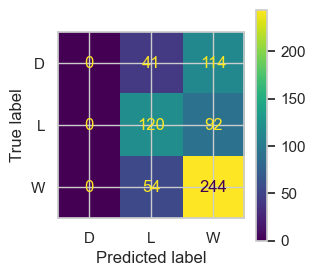

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5473684210526316
ROC score on Test Set: 0.7088696402636224

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.56      0.57      0.56       212
           2       0.54      0.82      0.65       298

    accuracy                           0.55       665
   macro avg       0.37      0.46      0.40       665
weighted avg       0.42      0.55      0.47       665



### Logistic Regression

#### Fold 1

In [21]:
# logistic regression
lr_classifier = LogisticRegression(C=0.62, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1192
1     848
0     620
Name: Result, dtype: int64
2    298
1    211
0    155
Name: Result, dtype: int64


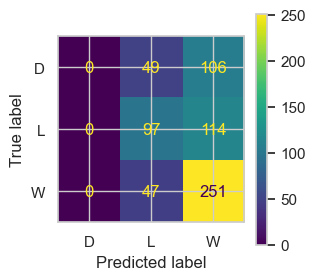

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5240963855421686
ROC score on Test Set: 0.6755677939801873

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.50      0.46      0.48       211
           2       0.53      0.84      0.65       298

    accuracy                           0.52       664
   macro avg       0.35      0.43      0.38       664
weighted avg       0.40      0.52      0.45       664



#### Fold 2

In [24]:
# logistic regression
lr_classifier = LogisticRegression(C=0.62, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


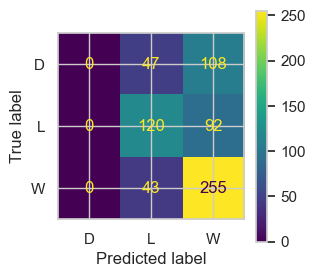

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5639097744360902
ROC score on Test Set: 0.7176096501969144

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.57      0.57      0.57       212
           2       0.56      0.86      0.68       298

    accuracy                           0.56       665
   macro avg       0.38      0.47      0.42       665
weighted avg       0.43      0.56      0.48       665



#### Fold 3

In [27]:
# logistic regression
lr_classifier = LogisticRegression(C=0.62, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


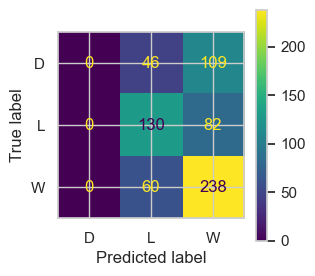

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5533834586466165
ROC score on Test Set: 0.6972416805034977

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.55      0.61      0.58       212
           2       0.55      0.80      0.65       298

    accuracy                           0.55       665
   macro avg       0.37      0.47      0.41       665
weighted avg       0.42      0.55      0.48       665



#### Fold 4

In [30]:
# logistic regression
lr_classifier = LogisticRegression(C=0.62, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


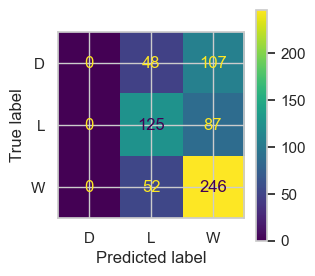

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5578947368421052
ROC score on Test Set: 0.7024836113225694

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.56      0.59      0.57       212
           2       0.56      0.83      0.67       298

    accuracy                           0.56       665
   macro avg       0.37      0.47      0.41       665
weighted avg       0.43      0.56      0.48       665



#### Fold 5

In [33]:
# logistic regression
lr_classifier = LogisticRegression(C=0.62, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


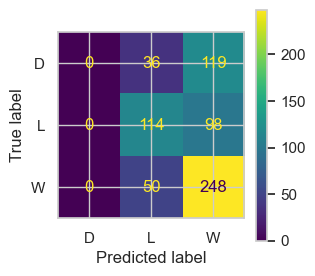

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [35]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.544360902255639
ROC score on Test Set: 0.7051884604094695

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.57      0.54      0.55       212
           2       0.53      0.83      0.65       298

    accuracy                           0.54       665
   macro avg       0.37      0.46      0.40       665
weighted avg       0.42      0.54      0.47       665



### SVM Classifier

#### Fold 1

In [36]:
# svm classifier
svc_classifier = SVC(C=10, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1192
1     848
0     620
Name: Result, dtype: int64
2    298
1    211
0    155
Name: Result, dtype: int64


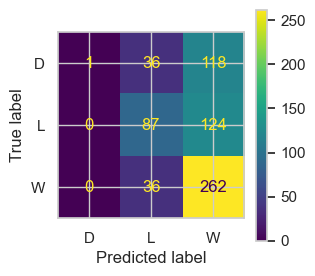

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5271084337349398
ROC score on Test Set: 0.6481204481088689

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       155
           1       0.55      0.41      0.47       211
           2       0.52      0.88      0.65       298

    accuracy                           0.53       664
   macro avg       0.69      0.43      0.38       664
weighted avg       0.64      0.53      0.45       664



#### Fold 2

In [39]:
# svm classifier
svc_classifier = SVC(C=10, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


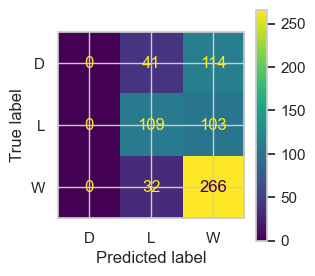

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5639097744360902
ROC score on Test Set: 0.6793031200796653

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.60      0.51      0.55       212
           2       0.55      0.89      0.68       298

    accuracy                           0.56       665
   macro avg       0.38      0.47      0.41       665
weighted avg       0.44      0.56      0.48       665



#### Fold 3

In [42]:
# svm classifier
svc_classifier = SVC(C=10, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


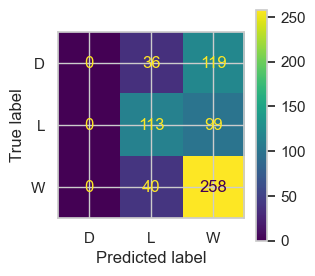

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5578947368421052
ROC score on Test Set: 0.6592099362417566

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.60      0.53      0.56       212
           2       0.54      0.87      0.67       298

    accuracy                           0.56       665
   macro avg       0.38      0.47      0.41       665
weighted avg       0.43      0.56      0.48       665



#### Fold 4

In [45]:
# svm classifier
svc_classifier = SVC(C=10, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


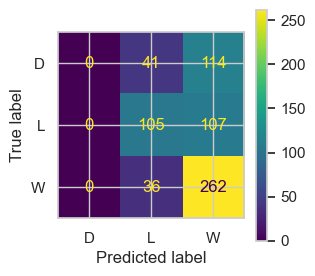

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [47]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5518796992481203
ROC score on Test Set: 0.6657250885610526

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.58      0.50      0.53       212
           2       0.54      0.88      0.67       298

    accuracy                           0.55       665
   macro avg       0.37      0.46      0.40       665
weighted avg       0.43      0.55      0.47       665



#### Fold 5

In [48]:
# svm classifier
svc_classifier = SVC(C=10, gamma=0.01, kernel='rbf', random_state = 0, probability=True)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


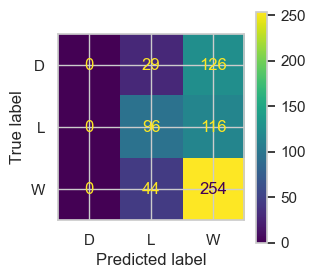

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [50]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5263157894736842
ROC score on Test Set: 0.6447892040892399

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.57      0.45      0.50       212
           2       0.51      0.85      0.64       298

    accuracy                           0.53       665
   macro avg       0.36      0.44      0.38       665
weighted avg       0.41      0.53      0.45       665



### XGBoost Classifier

#### Fold 1

In [51]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1192
1     848
0     620
Name: Result, dtype: int64
2    298
1    211
0    155
Name: Result, dtype: int64


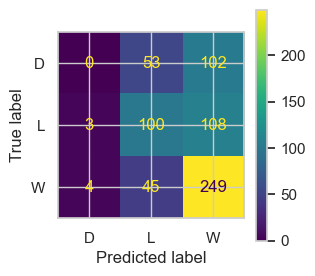

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5256024096385542
ROC score on Test Set: 0.6705207464881416

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.51      0.47      0.49       211
           2       0.54      0.84      0.66       298

    accuracy                           0.53       664
   macro avg       0.35      0.44      0.38       664
weighted avg       0.40      0.53      0.45       664



#### Fold 2

In [54]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


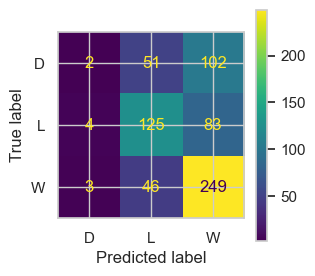

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5654135338345865
ROC score on Test Set: 0.7113745459149466

              precision    recall  f1-score   support

           0       0.22      0.01      0.02       155
           1       0.56      0.59      0.58       212
           2       0.57      0.84      0.68       298

    accuracy                           0.57       665
   macro avg       0.45      0.48      0.43       665
weighted avg       0.49      0.57      0.49       665



#### Fold 3

In [57]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


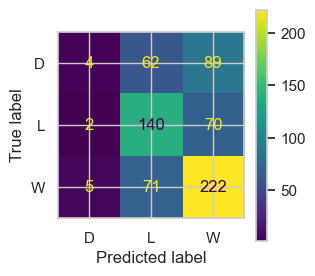

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5503759398496241
ROC score on Test Set: 0.7086478052556753

              precision    recall  f1-score   support

           0       0.36      0.03      0.05       155
           1       0.51      0.66      0.58       212
           2       0.58      0.74      0.65       298

    accuracy                           0.55       665
   macro avg       0.49      0.48      0.43       665
weighted avg       0.51      0.55      0.49       665



#### Fold 4

In [60]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


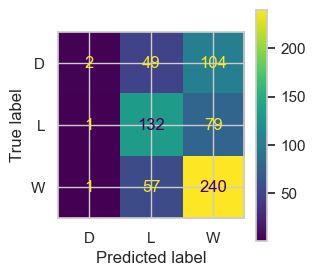

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.562406015037594
ROC score on Test Set: 0.7063528146938403

              precision    recall  f1-score   support

           0       0.50      0.01      0.03       155
           1       0.55      0.62      0.59       212
           2       0.57      0.81      0.67       298

    accuracy                           0.56       665
   macro avg       0.54      0.48      0.43       665
weighted avg       0.55      0.56      0.49       665



#### Fold 5

In [63]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=100)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
wdl_sc = StandardScaler()
X_train.iloc[:, :] = wdl_sc.fit_transform(X_train.iloc[:, :])
X_test.iloc[:, :] = wdl_sc.transform(X_test.iloc[:, :])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

2    1192
1     847
0     620
Name: Result, dtype: int64
2    298
1    212
0    155
Name: Result, dtype: int64


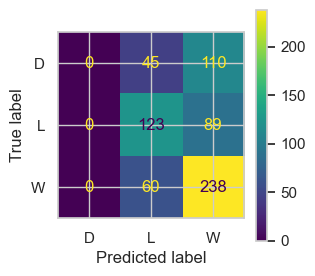

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [65]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5428571428571428
ROC score on Test Set: 0.7035176276293846

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.54      0.58      0.56       212
           2       0.54      0.80      0.65       298

    accuracy                           0.54       665
   macro avg       0.36      0.46      0.40       665
weighted avg       0.42      0.54      0.47       665

